# 1. Symmetries in NN and how to break them - Initialization

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.0 (17/12/2022)

**Requirements:**
- Python 3 (tested on v3.9.6)
- Matplotlib (tested on v3.5.1)
- Numpy (tested on v1.22.1)
- Sklearn (tested on v0.0.post1)

### Imports

In [1]:
# Matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
# Numpy
import numpy as np
# Sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
# Removing unecessary warnings (optional, just makes notebook outputs more readable)
import warnings
warnings.filterwarnings("ignore")

### Blast from the past - Mock dataset generation

As in Notebook 7.a., from W1.

In [2]:
# All helper functions
min_surf = 40
max_surf = 200
def surface(min_surf, max_surf):
    return round(np.random.uniform(min_surf, max_surf), 2)
min_dist = 50
max_dist = 1000
def distance(min_dist, max_dist):
    return round(np.random.uniform(min_dist, max_dist), 2)
def price(surface, distance):
    return round((100000 + 14373*surface + (1000 - distance)*1286)*(1 + np.random.uniform(-0.1, 0.1)))/1000000
n_points = 100
def create_dataset(n_points, min_surf, max_surf, min_dist, max_dist):
    surfaces_list = np.array([surface(min_surf, max_surf) for _ in range(n_points)])
    distances_list = np.array([distance(min_dist, max_dist) for _ in range(n_points)])
    inputs = np.array([[s, d] for s, d in zip(surfaces_list, distances_list)])
    outputs = np.array([price(s, d) for s, d in zip(surfaces_list, distances_list)]).reshape(n_points, 1)
    return surfaces_list, distances_list, inputs, outputs

In [3]:
# Generate dataset
np.random.seed(47)
surfaces_list, distances_list, inputs, outputs = create_dataset(n_points, min_surf, max_surf, min_dist, max_dist)
# Check a few entries of the dataset
print(surfaces_list.shape)
print(distances_list.shape)
print(inputs.shape)
print(outputs.shape)
print(inputs[0:10, :])
print(outputs[0:10])

(100,)
(100,)
(100, 2)
(100, 1)
[[ 58.16 572.97]
 [195.92 809.8 ]
 [156.6  349.04]
 [ 96.23  86.82]
 [153.22 817.92]
 [167.94 806.25]
 [143.29 315.92]
 [106.34 482.67]
 [152.96 427.77]
 [ 79.46 955.76]]
[[1.581913]
 [3.450274]
 [2.978769]
 [2.808258]
 [2.556398]
 [3.023983]
 [3.099523]
 [2.121069]
 [3.136544]
 [1.273443]]


### Blast from the past - ShallowNeuralNet class

As in Notebook 7.b., from W1.

In [4]:
class ShallowNeuralNet():
    
    def __init__(self, n_x, n_h, n_y):
        # Network dimensions
        self.n_x = n_x
        self.n_h = n_h
        self.n_y = n_y
        # Weights and biases matrices (randomly initialized)
        self.W1 = np.random.randn(n_x, n_h)*0.1
        self.b1 = np.random.randn(1, n_h)*0.1
        self.W2 = np.random.randn(n_h, n_y)*0.1
        self.b2 = np.random.randn(1, n_y)*0.1
        # Loss, initialized as infinity before first calculation is made
        self.loss = float("Inf")
        
    def forward(self, inputs):
        # Wx + b operation for the first layer
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        # Wx + b operation for the second layer
        Z2 = np.matmul(Z1_b, self.W2)
        Z2_b = Z2 + self.b2
        return Z2_b
    
    def MSE_loss(self, inputs, outputs):
        # MSE loss function as before
        outputs_re = outputs.reshape(-1, 1)
        pred = self.forward(inputs)
        losses = (pred - outputs_re)**2
        self.loss = np.sum(losses)/outputs.shape[0]
        return self.loss
    
    def backward(self, inputs, outputs, alpha = 1e-5):
        # Get the number of samples in dataset
        m = inputs.shape[0]
        
        # Forward propagate
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        Z2 = np.matmul(Z1_b, self.W2)
        y_pred = Z2 + self.b2
    
        # Compute error term
        epsilon = y_pred - outputs
    
        # Compute the gradient for W2 and b2
        dL_dW2 = (2/m)*np.matmul(Z1_b.T, epsilon)
        dL_db2 = (2/m)*np.sum(epsilon, axis = 0, keepdims = True)

        # Compute the loss derivative with respect to the first layer
        dL_dZ1 = np.matmul(epsilon, self.W2.T)

        # Compute the gradient for W1 and b1
        dL_dW1 = (2/m)*np.matmul(inputs.T, dL_dZ1)
        dL_db1 = (2/m)*np.sum(dL_dZ1, axis = 0, keepdims = True)

        # Update the weights and biases using gradient descent
        self.W1 -= alpha*dL_dW1
        self.b1 -= alpha*dL_db1
        self.W2 -= alpha*dL_dW2
        self.b2 -= alpha*dL_db2
        
        # Update loss
        self.MSE_loss(inputs, outputs)
    
    def train(self, N_max = 1000, alpha = 1e-5, beta = 1e-5, display = True):
        # List of losses, starts with the current loss
        self.losses_list = [self.loss]
        # Repeat iterations
        for iteration_number in range(1, N_max + 1):
            # Backpropagate
            self.backward(inputs, outputs, alpha)
            new_loss = self.loss
            # Update losses list
            self.losses_list.append(new_loss)
            # Display
            if(display):
                print("Iteration {} - Loss = {}".format(iteration_number, new_loss))
            # Check for beta value and early stop criterion
            difference = abs(self.losses_list[-1] - self.losses_list[-2])
            if(difference < beta):
                if(display):
                    print("Stopping early - loss evolution was less than beta.")
                break
        else:
            # Else on for loop will execute if break did not trigger
            if(display):
                print("Stopping - Maximal number of iterations reached.")
    
    def show_losses_over_training(self):
        # Initialize matplotlib
        fig, axs = plt.subplots(1, 2, figsize = (15, 5))
        axs[0].plot(list(range(len(self.losses_list))), self.losses_list)
        axs[0].set_xlabel("Iteration number")
        axs[0].set_ylabel("Loss")
        axs[1].plot(list(range(len(self.losses_list))), self.losses_list)
        axs[1].set_xlabel("Iteration number")
        axs[1].set_ylabel("Loss (in logarithmic scale)")
        axs[1].set_yscale("log")
        # Display
        plt.show()

### A constant initialization ShallowNeuralNet class

We will reuse and amend the **ShallowNeuralNet** class from Noteook 7.b. (Week 1) to produce a **ShallowNeuralNet_ConstantInit** class.

In the **__init__()** method of the class, we initialized the weights and biases matrices using some random generators. Let us now assume that the matrices are intialized as matrices filled with constant values, e.g. constant matrices filled with the same values 0.1.

We will therefore change the lines:
```
self.W1 = np.random.randn(n_x, n_h)*0.1
self.b1 = np.random.randn(1, n_h)*0.1
self.W2 = np.random.randn(n_h, n_y)*0.1
self.b2 = np.random.randn(1, n_y)*0.1
```
We will replace them with:
```
self.W1 = np.ones(shape = (n_x, n_h))*const_val
self.b1 = np.ones(shape = (1, n_h))*const_val
self.W2 = np.ones(shape = (n_h, n_y))*const_val
self.b2 = np.ones(shape = (1, n_y))*const_val
```
Where **const_val** is a new parameter required for the class initialization.

In addition, our **train()** method will have additional lines to display for the values of $ W1 $, $ b_1 $, $ W_2 $ and $ b_2 $ after each iteration:
```
print("Iteration {} - Loss = {}".format(iteration_number, new_loss))
print("W1, b1, W2, b2: ")
print(self.W1)
print(self.b1)
print(self.W2)
print(self.b2)
```

In [5]:
class ShallowNeuralNet_ConstantInit():
    
    def __init__(self, n_x, n_h, n_y, const_val):
        # Network dimensions
        self.n_x = n_x
        self.n_h = n_h
        self.n_y = n_y
        # Weights and biases matrices (all initialized as constant
        # matrices filled with 0.1 values)
        self.W1 = np.ones(shape = (n_x, n_h))*const_val
        self.b1 = np.ones(shape = (1, n_h))*const_val
        self.W2 = np.ones(shape = (n_h, n_y))*const_val
        self.b2 = np.ones(shape = (1, n_y))*const_val
        # Loss, initialized as infinity before first calculation is made
        self.loss = float("Inf")
        
    def forward(self, inputs):
        # Wx + b operation for the first layer
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        # Wx + b operation for the second layer
        Z2 = np.matmul(Z1_b, self.W2)
        Z2_b = Z2 + self.b2
        return Z2_b
    
    def MSE_loss(self, inputs, outputs):
        # MSE loss function as before
        outputs_re = outputs.reshape(-1, 1)
        pred = self.forward(inputs)
        losses = (pred - outputs_re)**2
        self.loss = np.sum(losses)/outputs.shape[0]
        return self.loss
    
    def backward(self, inputs, outputs, alpha = 1e-5):
        # Get the number of samples in dataset
        m = inputs.shape[0]
        
        # Forward propagate
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        Z2 = np.matmul(Z1_b, self.W2)
        y_pred = Z2 + self.b2
    
        # Compute error term
        epsilon = y_pred - outputs
    
        # Compute the gradient for W2 and b2
        dL_dW2 = (2/m)*np.matmul(Z1_b.T, epsilon)
        dL_db2 = (2/m)*np.sum(epsilon, axis = 0, keepdims = True)

        # Compute the loss derivative with respect to the first layer
        dL_dZ1 = np.matmul(epsilon, self.W2.T)

        # Compute the gradient for W1 and b1
        dL_dW1 = (2/m)*np.matmul(inputs.T, dL_dZ1)
        dL_db1 = (2/m)*np.sum(dL_dZ1, axis = 0, keepdims = True)

        # Update the weights and biases using gradient descent
        self.W1 -= alpha*dL_dW1
        self.b1 -= alpha*dL_db1
        self.W2 -= alpha*dL_dW2
        self.b2 -= alpha*dL_db2
        
        # Update loss
        self.MSE_loss(inputs, outputs)
    
    def train(self, N_max = 1000, alpha = 1e-5, beta = 1e-5, display = True):
        # List of losses, starts with the current loss
        self.losses_list = [self.loss]
        # Repeat iterations
        for iteration_number in range(1, N_max + 1):
            # Backpropagate
            self.backward(inputs, outputs, alpha)
            new_loss = self.loss
            # Update losses list
            self.losses_list.append(new_loss)
            # Display
            if(display):
                print("Iteration {} - Loss = {}".format(iteration_number, new_loss))
                print("W1, b1, W2, b2: ")
                print(self.W1)
                print(self.b1)
                print(self.W2)
                print(self.b2)
            # Check for beta value and early stop criterion
            difference = abs(self.losses_list[-1] - self.losses_list[-2])
            if(difference < beta):
                if(display):
                    print("Stopping early - loss evolution was less than beta.")
                break
        else:
            # Else on for loop will execute if break did not trigger
            if(display):
                print("Stopping - Maximal number of iterations reached.")
    
    def show_losses_over_training(self):
        # Initialize matplotlib
        fig, axs = plt.subplots(1, 2, figsize = (15, 5))
        axs[0].plot(list(range(len(self.losses_list))), self.losses_list)
        axs[0].set_xlabel("Iteration number")
        axs[0].set_ylabel("Loss")
        axs[1].plot(list(range(len(self.losses_list))), self.losses_list)
        axs[1].set_xlabel("Iteration number")
        axs[1].set_ylabel("Loss (in logarithmic scale)")
        axs[1].set_yscale("log")
        # Display
        plt.show()

What needs to be observed here, is that the parameters $ W1 $, $ b_1 $, $ W_2 $ and $ b_2 $ are getting updated by the gradient descent algorithm as before, however, the values of the elements inside of these matrices will remain the same.

In [6]:
# Define neural network structure
n_x = 2
n_h = 4
n_y = 1
np.random.seed(37)
shallow_neural_net = ShallowNeuralNet_ConstantInit(n_x, n_h, n_y, 0.1)
shallow_neural_net.train(N_max = 10000, alpha = 1e-6, beta = 1e-6, display = True)

Iteration 1 - Loss = 618.4538740049891
W1, b1, W2, b2: 
[[0.09938446 0.09938446 0.09938446 0.09938446]
 [0.09676805 0.09676805 0.09676805 0.09676805]]
[[0.09999521 0.09999521 0.09999521 0.09999521]]
[[0.09614772]
 [0.09614772]
 [0.09614772]
 [0.09614772]]
[[0.09995206]]
Iteration 2 - Loss = 539.395679272708
W1, b1, W2, b2: 
[[0.09883476 0.09883476 0.09883476 0.09883476]
 [0.09387968 0.09387968 0.09387968 0.09387968]]
[[0.09999093 0.09999093 0.09999093 0.09999093]]
[[0.09266806]
 [0.09266806]
 [0.09266806]
 [0.09266806]]
[[0.09990755]]
Iteration 3 - Loss = 474.34666193530967
W1, b1, W2, b2: 
[[0.09834035 0.09834035 0.09834035 0.09834035]
 [0.09127975 0.09127975 0.09127975 0.09127975]]
[[0.09998708 0.09998708 0.09998708 0.09998708]]
[[0.08950266]
 [0.08950266]
 [0.08950266]
 [0.08950266]]
[[0.09986601]]
Iteration 4 - Loss = 420.1735379302215
W1, b1, W2, b2: 
[[0.09789291 0.09789291 0.09789291 0.09789291]
 [0.0889248  0.0889248  0.0889248  0.0889248 ]]
[[0.09998359 0.09998359 0.09998359 0

[[0.01490906]
 [0.01490906]
 [0.01490906]
 [0.01490906]]
[[0.09870981]]
Iteration 347 - Loss = 1.3857764981752552
W1, b1, W2, b2: 
[[0.0904236  0.0904236  0.0904236  0.0904236 ]
 [0.04489628 0.04489628 0.04489628 0.04489628]]
[[0.09992485 0.09992485 0.09992485 0.09992485]]
[[0.01490367]
 [0.01490367]
 [0.01490367]
 [0.01490367]]
[[0.09871037]]
Iteration 348 - Loss = 1.3855797278160034
W1, b1, W2, b2: 
[[0.0904249  0.0904249  0.0904249  0.0904249 ]
 [0.04489188 0.04489188 0.04489188 0.04489188]]
[[0.09992485 0.09992485 0.09992485 0.09992485]]
[[0.01489836]
 [0.01489836]
 [0.01489836]
 [0.01489836]]
[[0.09871093]]
Iteration 349 - Loss = 1.385386656792746
W1, b1, W2, b2: 
[[0.0904262  0.0904262  0.0904262  0.0904262 ]
 [0.04488749 0.04488749 0.04488749 0.04488749]]
[[0.09992486 0.09992486 0.09992486 0.09992486]]
[[0.01489312]
 [0.01489312]
 [0.01489312]
 [0.01489312]]
[[0.09871149]]
Iteration 350 - Loss = 1.3851971936360652
W1, b1, W2, b2: 
[[0.09042751 0.09042751 0.09042751 0.09042751]
 

[[0.09905155]]
Iteration 854 - Loss = 1.3557541306607996
W1, b1, W2, b2: 
[[0.0911833  0.0911833  0.0911833  0.0911833 ]
 [0.04327058 0.04327058 0.04327058 0.04327058]]
[[0.09992986 0.09992986 0.09992986 0.09992986]]
[[0.01475638]
 [0.01475638]
 [0.01475638]
 [0.01475638]]
[[0.09905224]]
Iteration 855 - Loss = 1.3557056125161315
W1, b1, W2, b2: 
[[0.09118484 0.09118484 0.09118484 0.09118484]
 [0.04326755 0.04326755 0.04326755 0.04326755]]
[[0.09992987 0.09992987 0.09992987 0.09992987]]
[[0.01475707]
 [0.01475707]
 [0.01475707]
 [0.01475707]]
[[0.09905293]]
Iteration 856 - Loss = 1.355657087909087
W1, b1, W2, b2: 
[[0.09118638 0.09118638 0.09118638 0.09118638]
 [0.04326452 0.04326452 0.04326452 0.04326452]]
[[0.09992988 0.09992988 0.09992988 0.09992988]]
[[0.01475776]
 [0.01475776]
 [0.01475776]
 [0.01475776]]
[[0.09905362]]
Iteration 857 - Loss = 1.3556085568376455
W1, b1, W2, b2: 
[[0.09118791 0.09118791 0.09118791 0.09118791]
 [0.0432615  0.0432615  0.0432615  0.0432615 ]]
[[0.099929

Iteration 921 - Loss = 1.3524890355788386
W1, b1, W2, b2: 
[[0.09128634 0.09128634 0.09128634 0.09128634]
 [0.04306721 0.04306721 0.04306721 0.04306721]]
[[0.09993054 0.09993054 0.09993054 0.09993054]]
[[0.01480304]
 [0.01480304]
 [0.01480304]
 [0.01480304]]
[[0.0990985]]
Iteration 922 - Loss = 1.3524400803208212
W1, b1, W2, b2: 
[[0.09128788 0.09128788 0.09128788 0.09128788]
 [0.04306417 0.04306417 0.04306417 0.04306417]]
[[0.09993055 0.09993055 0.09993055 0.09993055]]
[[0.01480374]
 [0.01480374]
 [0.01480374]
 [0.01480374]]
[[0.09909919]]
Iteration 923 - Loss = 1.352391118478748
W1, b1, W2, b2: 
[[0.09128942 0.09128942 0.09128942 0.09128942]
 [0.04306113 0.04306113 0.04306113 0.04306113]]
[[0.09993056 0.09993056 0.09993056 0.09993056]]
[[0.01480444]
 [0.01480444]
 [0.01480444]
 [0.01480444]]
[[0.09909988]]
Iteration 924 - Loss = 1.3523421500509238
W1, b1, W2, b2: 
[[0.09129096 0.09129096 0.09129096 0.09129096]
 [0.04305808 0.04305808 0.04305808 0.04305808]]
[[0.09993057 0.09993057 0.

[[0.09945632]]
Iteration 1446 - Loss = 1.3258417670171516
W1, b1, W2, b2: 
[[0.09209554 0.09209554 0.09209554 0.09209554]
 [0.0414369  0.0414369  0.0414369  0.0414369 ]]
[[0.09993592 0.09993592 0.09993592 0.09993592]]
[[0.01519285]
 [0.01519285]
 [0.01519285]
 [0.01519285]]
[[0.09945699]]
Iteration 1447 - Loss = 1.3257891229082142
W1, b1, W2, b2: 
[[0.09209708 0.09209708 0.09209708 0.09209708]
 [0.04143373 0.04143373 0.04143373 0.04143373]]
[[0.09993593 0.09993593 0.09993593 0.09993593]]
[[0.01519363]
 [0.01519363]
 [0.01519363]
 [0.01519363]]
[[0.09945767]]
Iteration 1448 - Loss = 1.3257364713095314
W1, b1, W2, b2: 
[[0.09209863 0.09209863 0.09209863 0.09209863]
 [0.04143056 0.04143056 0.04143056 0.04143056]]
[[0.09993594 0.09993594 0.09993594 0.09993594]]
[[0.01519441]
 [0.01519441]
 [0.01519441]
 [0.01519441]]
[[0.09945834]]
Iteration 1449 - Loss = 1.3256838122192476
W1, b1, W2, b2: 
[[0.09210017 0.09210017 0.09210017 0.09210017]
 [0.04142739 0.04142739 0.04142739 0.04142739]]
[[0.0

[[0.09993622 0.09993622 0.09993622 0.09993622]]
[[0.01521628]
 [0.01521628]
 [0.01521628]
 [0.01521628]]
[[0.09947726]]
Iteration 1477 - Loss = 1.3242063085498292
W1, b1, W2, b2: 
[[0.09214341 0.09214341 0.09214341 0.09214341]
 [0.04133848 0.04133848 0.04133848 0.04133848]]
[[0.09993624 0.09993624 0.09993624 0.09993624]]
[[0.01521707]
 [0.01521707]
 [0.01521707]
 [0.01521707]]
[[0.09947793]]
Iteration 1478 - Loss = 1.3241534313933823
W1, b1, W2, b2: 
[[0.09214496 0.09214496 0.09214496 0.09214496]
 [0.0413353  0.0413353  0.0413353  0.0413353 ]]
[[0.09993625 0.09993625 0.09993625 0.09993625]]
[[0.01521785]
 [0.01521785]
 [0.01521785]
 [0.01521785]]
[[0.09947861]]
Iteration 1479 - Loss = 1.3241005466894027
W1, b1, W2, b2: 
[[0.0921465  0.0921465  0.0921465  0.0921465 ]
 [0.04133212 0.04133212 0.04133212 0.04133212]]
[[0.09993626 0.09993626 0.09993626 0.09993626]]
[[0.01521863]
 [0.01521863]
 [0.01521863]
 [0.01521863]]
[[0.09947928]]
Iteration 1480 - Loss = 1.3240476544360147
W1, b1, W2, 

[[0.09981791]]
Iteration 1987 - Loss = 1.2962164871636812
W1, b1, W2, b2: 
[[0.0929324  0.0929324  0.0929324  0.0929324 ]
 [0.03968292 0.03968292 0.03968292 0.03968292]]
[[0.09994149 0.09994149 0.09994149 0.09994149]]
[[0.01563612]
 [0.01563612]
 [0.01563612]
 [0.01563612]]
[[0.09981857]]
Iteration 1988 - Loss = 1.2961595043631489
W1, b1, W2, b2: 
[[0.09293394 0.09293394 0.09293394 0.09293394]
 [0.0396796  0.0396796  0.0396796  0.0396796 ]]
[[0.0999415 0.0999415 0.0999415 0.0999415]]
[[0.01563698]
 [0.01563698]
 [0.01563698]
 [0.01563698]]
[[0.09981923]]
Iteration 1989 - Loss = 1.2961025129803532
W1, b1, W2, b2: 
[[0.09293549 0.09293549 0.09293549 0.09293549]
 [0.03967629 0.03967629 0.03967629 0.03967629]]
[[0.09994151 0.09994151 0.09994151 0.09994151]]
[[0.01563784]
 [0.01563784]
 [0.01563784]
 [0.01563784]]
[[0.09981989]]
Iteration 1990 - Loss = 1.2960455130131021
W1, b1, W2, b2: 
[[0.09293704 0.09293704 0.09293704 0.09293704]
 [0.03967297 0.03967297 0.03967297 0.03967297]]
[[0.09994

[[0.09994184 0.09994184 0.09994184 0.09994184]]
[[0.01566551]
 [0.01566551]
 [0.01566551]
 [0.01566551]]
[[0.09984101]]
Iteration 2022 - Loss = 1.2942169683068472
W1, b1, W2, b2: 
[[0.09298664 0.09298664 0.09298664 0.09298664]
 [0.03956671 0.03956671 0.03956671 0.03956671]]
[[0.09994185 0.09994185 0.09994185 0.09994185]]
[[0.01566638]
 [0.01566638]
 [0.01566638]
 [0.01566638]]
[[0.09984167]]
Iteration 2023 - Loss = 1.2941596838175484
W1, b1, W2, b2: 
[[0.09298819 0.09298819 0.09298819 0.09298819]
 [0.03956339 0.03956339 0.03956339 0.03956339]]
[[0.09994186 0.09994186 0.09994186 0.09994186]]
[[0.01566725]
 [0.01566725]
 [0.01566725]
 [0.01566725]]
[[0.09984233]]
Iteration 2024 - Loss = 1.294102390668811
W1, b1, W2, b2: 
[[0.09298974 0.09298974 0.09298974 0.09298974]
 [0.03956006 0.03956006 0.03956006 0.03956006]]
[[0.09994187 0.09994187 0.09994187 0.09994187]]
[[0.01566811]
 [0.01566811]
 [0.01566811]
 [0.01566811]]
[[0.09984299]]
Iteration 2025 - Loss = 1.2940450888584158
W1, b1, W2, b

[[0.10020972]]
Iteration 2588 - Loss = 1.2603396979861419
W1, b1, W2, b2: 
[[0.09386547 0.09386547 0.09386547 0.09386547]
 [0.03763889 0.03763889 0.03763889 0.03763889]]
[[0.09994772 0.09994772 0.09994772 0.09994772]]
[[0.01618561]
 [0.01618561]
 [0.01618561]
 [0.01618561]]
[[0.10021036]]
Iteration 2589 - Loss = 1.260277136266936
W1, b1, W2, b2: 
[[0.09386702 0.09386702 0.09386702 0.09386702]
 [0.0376354  0.0376354  0.0376354  0.0376354 ]]
[[0.09994773 0.09994773 0.09994773 0.09994773]]
[[0.01618658]
 [0.01618658]
 [0.01618658]
 [0.01618658]]
[[0.100211]]
Iteration 2590 - Loss = 1.2602145645176965
W1, b1, W2, b2: 
[[0.09386858 0.09386858 0.09386858 0.09386858]
 [0.03763191 0.03763191 0.03763191 0.03763191]]
[[0.09994774 0.09994774 0.09994774 0.09994774]]
[[0.01618755]
 [0.01618755]
 [0.01618755]
 [0.01618755]]
[[0.10021165]]
Iteration 2591 - Loss = 1.2601519827357865
W1, b1, W2, b2: 
[[0.09387013 0.09387013 0.09387013 0.09387013]
 [0.03762842 0.03762842 0.03762842 0.03762842]]
[[0.0999

[[0.01625695]
 [0.01625695]
 [0.01625695]
 [0.01625695]]
[[0.10025721]]
Iteration 2662 - Loss = 1.2556828677776362
W1, b1, W2, b2: 
[[0.09398059 0.09398059 0.09398059 0.09398059]
 [0.03737986 0.03737986 0.03737986 0.03737986]]
[[0.09994849 0.09994849 0.09994849 0.09994849]]
[[0.01625793]
 [0.01625793]
 [0.01625793]
 [0.01625793]]
[[0.10025785]]
Iteration 2663 - Loss = 1.2556195566612922
W1, b1, W2, b2: 
[[0.09398215 0.09398215 0.09398215 0.09398215]
 [0.03737635 0.03737635 0.03737635 0.03737635]]
[[0.0999485 0.0999485 0.0999485 0.0999485]]
[[0.01625891]
 [0.01625891]
 [0.01625891]
 [0.01625891]]
[[0.10025849]]
Iteration 2664 - Loss = 1.2555562353176046
W1, b1, W2, b2: 
[[0.0939837  0.0939837  0.0939837  0.0939837 ]
 [0.03737283 0.03737283 0.03737283 0.03737283]]
[[0.09994851 0.09994851 0.09994851 0.09994851]]
[[0.0162599]
 [0.0162599]
 [0.0162599]
 [0.0162599]]
[[0.10025913]]
Iteration 2665 - Loss = 1.255492903743878
W1, b1, W2, b2: 
[[0.09398526 0.09398526 0.09398526 0.09398526]
 [0.0

[[0.01685815]
 [0.01685815]
 [0.01685815]
 [0.01685815]]
[[0.10062043]]
Iteration 3237 - Loss = 1.217502469787527
W1, b1, W2, b2: 
[[0.09487682 0.09487682 0.09487682 0.09487682]
 [0.03530886 0.03530886 0.03530886 0.03530886]]
[[0.0999545 0.0999545 0.0999545 0.0999545]]
[[0.01685926]
 [0.01685926]
 [0.01685926]
 [0.01685926]]
[[0.10062105]]
Iteration 3238 - Loss = 1.2174328066232014
W1, b1, W2, b2: 
[[0.09487838 0.09487838 0.09487838 0.09487838]
 [0.03530517 0.03530517 0.03530517 0.03530517]]
[[0.09995451 0.09995451 0.09995451 0.09995451]]
[[0.01686037]
 [0.01686037]
 [0.01686037]
 [0.01686037]]
[[0.10062168]]
Iteration 3239 - Loss = 1.2173631315419555
W1, b1, W2, b2: 
[[0.09487994 0.09487994 0.09487994 0.09487994]
 [0.03530148 0.03530148 0.03530148 0.03530148]]
[[0.09995452 0.09995452 0.09995452 0.09995452]]
[[0.01686148]
 [0.01686148]
 [0.01686148]
 [0.01686148]]
[[0.1006223]]
Iteration 3240 - Loss = 1.2172934445405983
W1, b1, W2, b2: 
[[0.0948815  0.0948815  0.0948815  0.0948815 ]
 [

[[0.10066207]]
Iteration 3304 - Loss = 1.212808536004982
W1, b1, W2, b2: 
[[0.09498143 0.09498143 0.09498143 0.09498143]
 [0.03506062 0.03506062 0.03506062 0.03506062]]
[[0.0999552 0.0999552 0.0999552 0.0999552]]
[[0.01693421]
 [0.01693421]
 [0.01693421]
 [0.01693421]]
[[0.10066269]]
Iteration 3305 - Loss = 1.2127380673129513
W1, b1, W2, b2: 
[[0.09498299 0.09498299 0.09498299 0.09498299]
 [0.03505691 0.03505691 0.03505691 0.03505691]]
[[0.09995521 0.09995521 0.09995521 0.09995521]]
[[0.01693534]
 [0.01693534]
 [0.01693534]
 [0.01693534]]
[[0.10066331]]
Iteration 3306 - Loss = 1.2126675864883498
W1, b1, W2, b2: 
[[0.09498456 0.09498456 0.09498456 0.09498456]
 [0.03505319 0.03505319 0.03505319 0.03505319]]
[[0.09995523 0.09995523 0.09995523 0.09995523]]
[[0.01693646]
 [0.01693646]
 [0.01693646]
 [0.01693646]]
[[0.10066393]]
Iteration 3307 - Loss = 1.2125970935279289
W1, b1, W2, b2: 
[[0.09498612 0.09498612 0.09498612 0.09498612]
 [0.03504947 0.03504947 0.03504947 0.03504947]]
[[0.099955

[[0.09996078 0.09996078 0.09996078 0.09996078]]
[[0.01756627]
 [0.01756627]
 [0.01756627]
 [0.01756627]]
[[0.10098619]]
Iteration 3834 - Loss = 1.1736762262715876
W1, b1, W2, b2: 
[[0.09581021 0.09581021 0.09581021 0.09581021]
 [0.03304337 0.03304337 0.03304337 0.03304337]]
[[0.09996079 0.09996079 0.09996079 0.09996079]]
[[0.01756754]
 [0.01756754]
 [0.01756754]
 [0.01756754]]
[[0.10098679]]
Iteration 3835 - Loss = 1.1735988495664844
W1, b1, W2, b2: 
[[0.09581178 0.09581178 0.09581178 0.09581178]
 [0.03303948 0.03303948 0.03303948 0.03303948]]
[[0.0999608 0.0999608 0.0999608 0.0999608]]
[[0.0175688]
 [0.0175688]
 [0.0175688]
 [0.0175688]]
[[0.1009874]]
Iteration 3836 - Loss = 1.1735214588803202
W1, b1, W2, b2: 
[[0.09581334 0.09581334 0.09581334 0.09581334]
 [0.03303558 0.03303558 0.03303558 0.03303558]]
[[0.09996081 0.09996081 0.09996081 0.09996081]]
[[0.01757007]
 [0.01757007]
 [0.01757007]
 [0.01757007]]
[[0.100988]]
Iteration 3837 - Loss = 1.1734440542093696
W1, b1, W2, b2: 
[[0.09

[[0.10114349]]
Iteration 4097 - Loss = 1.1528331283865887
W1, b1, W2, b2: 
[[0.09622222 0.09622222 0.09622222 0.09622222]
 [0.03200588 0.03200588 0.03200588 0.03200588]]
[[0.09996358 0.09996358 0.09996358 0.09996358]]
[[0.01791098]
 [0.01791098]
 [0.01791098]
 [0.01791098]]
[[0.10114408]]
Iteration 4098 - Loss = 1.1527519437300937
W1, b1, W2, b2: 
[[0.09622379 0.09622379 0.09622379 0.09622379]
 [0.03200189 0.03200189 0.03200189 0.03200189]]
[[0.09996359 0.09996359 0.09996359 0.09996359]]
[[0.01791233]
 [0.01791233]
 [0.01791233]
 [0.01791233]]
[[0.10114467]]
Iteration 4099 - Loss = 1.1526707440832857
W1, b1, W2, b2: 
[[0.09622536 0.09622536 0.09622536 0.09622536]
 [0.0319979  0.0319979  0.0319979  0.0319979 ]]
[[0.0999636 0.0999636 0.0999636 0.0999636]]
[[0.01791367]
 [0.01791367]
 [0.01791367]
 [0.01791367]]
[[0.10114527]]
Iteration 4100 - Loss = 1.1525895294422175
W1, b1, W2, b2: 
[[0.09622693 0.09622693 0.09622693 0.09622693]
 [0.03199391 0.03199391 0.03199391 0.03199391]]
[[0.09996

[[0.09665663 0.09665663 0.09665663 0.09665663]
 [0.03088602 0.03088602 0.03088602 0.03088602]]
[[0.09996653 0.09996653 0.09996653 0.09996653]]
[[0.01829609]
 [0.01829609]
 [0.01829609]
 [0.01829609]]
[[0.10130712]]
Iteration 4375 - Loss = 1.1296724513253609
W1, b1, W2, b2: 
[[0.0966582  0.0966582  0.0966582  0.0966582 ]
 [0.03088193 0.03088193 0.03088193 0.03088193]]
[[0.09996654 0.09996654 0.09996654 0.09996654]]
[[0.01829753]
 [0.01829753]
 [0.01829753]
 [0.01829753]]
[[0.1013077]]
Iteration 4376 - Loss = 1.129586944664975
W1, b1, W2, b2: 
[[0.09665977 0.09665977 0.09665977 0.09665977]
 [0.03087783 0.03087783 0.03087783 0.03087783]]
[[0.09996656 0.09996656 0.09996656 0.09996656]]
[[0.01829896]
 [0.01829896]
 [0.01829896]
 [0.01829896]]
[[0.10130829]]
Iteration 4377 - Loss = 1.1295014218878663
W1, b1, W2, b2: 
[[0.09666134 0.09666134 0.09666134 0.09666134]
 [0.03087374 0.03087374 0.03087374 0.03087374]]
[[0.09996657 0.09996657 0.09996657 0.09996657]]
[[0.0183004]
 [0.0183004]
 [0.0183

[[0.09722026 0.09722026 0.09722026 0.09722026]
 [0.02939218 0.02939218 0.02939218 0.02939218]]
[[0.09997038 0.09997038 0.09997038 0.09997038]]
[[0.01883445]
 [0.01883445]
 [0.01883445]
 [0.01883445]]
[[0.10151434]]
Iteration 4734 - Loss = 1.0979077478539656
W1, b1, W2, b2: 
[[0.09722183 0.09722183 0.09722183 0.09722183]
 [0.02938795 0.02938795 0.02938795 0.02938795]]
[[0.09997039 0.09997039 0.09997039 0.09997039]]
[[0.01883601]
 [0.01883601]
 [0.01883601]
 [0.01883601]]
[[0.10151491]]
Iteration 4735 - Loss = 1.097816184237233
W1, b1, W2, b2: 
[[0.0972234  0.0972234  0.0972234  0.0972234 ]
 [0.02938372 0.02938372 0.02938372 0.02938372]]
[[0.0999704 0.0999704 0.0999704 0.0999704]]
[[0.01883758]
 [0.01883758]
 [0.01883758]
 [0.01883758]]
[[0.10151548]]
Iteration 4736 - Loss = 1.0977246029790728
W1, b1, W2, b2: 
[[0.09722497 0.09722497 0.09722497 0.09722497]
 [0.02937949 0.02937949 0.02937949 0.02937949]]
[[0.09997041 0.09997041 0.09997041 0.09997041]]
[[0.01883914]
 [0.01883914]
 [0.01883

[[0.09761309 0.09761309 0.09761309 0.09761309]
 [0.02832306 0.02832306 0.02832306 0.02832306]]
[[0.09997307 0.09997307 0.09997307 0.09997307]]
[[0.01923806]
 [0.01923806]
 [0.01923806]
 [0.01923806]]
[[0.10165587]]
Iteration 4984 - Loss = 1.0744565990322053
W1, b1, W2, b2: 
[[0.09761466 0.09761466 0.09761466 0.09761466]
 [0.02831873 0.02831873 0.02831873 0.02831873]]
[[0.09997308 0.09997308 0.09997308 0.09997308]]
[[0.01923972]
 [0.01923972]
 [0.01923972]
 [0.01923972]]
[[0.10165643]]
Iteration 4985 - Loss = 1.074360490031391
W1, b1, W2, b2: 
[[0.09761623 0.09761623 0.09761623 0.09761623]
 [0.02831441 0.02831441 0.02831441 0.02831441]]
[[0.09997309 0.09997309 0.09997309 0.09997309]]
[[0.01924139]
 [0.01924139]
 [0.01924139]
 [0.01924139]]
[[0.10165699]]
Iteration 4986 - Loss = 1.0742643623036552
W1, b1, W2, b2: 
[[0.0976178  0.0976178  0.0976178  0.0976178 ]
 [0.02831008 0.02831008 0.02831008 0.02831008]]
[[0.09997311 0.09997311 0.09997311 0.09997311]]
[[0.01924305]
 [0.01924305]
 [0.0

[[0.09805331 0.09805331 0.09805331 0.09805331]
 [0.0270973  0.0270973  0.0270973  0.0270973 ]]
[[0.09997611 0.09997611 0.09997611 0.09997611]]
[[0.01972079]
 [0.01972079]
 [0.01972079]
 [0.01972079]]
[[0.10181163]]
Iteration 5264 - Loss = 1.0467989428490205
W1, b1, W2, b2: 
[[0.09805489 0.09805489 0.09805489 0.09805489]
 [0.02709287 0.02709287 0.02709287 0.02709287]]
[[0.09997612 0.09997612 0.09997612 0.09997612]]
[[0.01972258]
 [0.01972258]
 [0.01972258]
 [0.01972258]]
[[0.10181218]]
Iteration 5265 - Loss = 1.0466974216307046
W1, b1, W2, b2: 
[[0.09805646 0.09805646 0.09805646 0.09805646]
 [0.02708844 0.02708844 0.02708844 0.02708844]]
[[0.09997613 0.09997613 0.09997613 0.09997613]]
[[0.01972436]
 [0.01972436]
 [0.01972436]
 [0.01972436]]
[[0.10181273]]
Iteration 5266 - Loss = 1.0465958804820337
W1, b1, W2, b2: 
[[0.09805803 0.09805803 0.09805803 0.09805803]
 [0.027084   0.027084   0.027084   0.027084  ]]
[[0.09997614 0.09997614 0.09997614 0.09997614]]
[[0.01972615]
 [0.01972615]
 [0.

[[0.0985661  0.0985661  0.0985661  0.0985661 ]
 [0.02563257 0.02563257 0.02563257 0.02563257]]
[[0.09997966 0.09997966 0.09997966 0.09997966]]
[[0.02032741]
 [0.02032741]
 [0.02032741]
 [0.02032741]]
[[0.10198928]]
Iteration 5590 - Loss = 1.0126235279230098
W1, b1, W2, b2: 
[[0.09856768 0.09856768 0.09856768 0.09856768]
 [0.02562802 0.02562802 0.02562802 0.02562802]]
[[0.09997967 0.09997967 0.09997967 0.09997967]]
[[0.02032935]
 [0.02032935]
 [0.02032935]
 [0.02032935]]
[[0.10198982]]
Iteration 5591 - Loss = 1.012515291817377
W1, b1, W2, b2: 
[[0.09856925 0.09856925 0.09856925 0.09856925]
 [0.02562346 0.02562346 0.02562346 0.02562346]]
[[0.09997968 0.09997968 0.09997968 0.09997968]]
[[0.02033129]
 [0.02033129]
 [0.02033129]
 [0.02033129]]
[[0.10199036]]
Iteration 5592 - Loss = 1.01240703446572
W1, b1, W2, b2: 
[[0.09857082 0.09857082 0.09857082 0.09857082]
 [0.02561891 0.02561891 0.02561891 0.02561891]]
[[0.0999797 0.0999797 0.0999797 0.0999797]]
[[0.02033323]
 [0.02033323]
 [0.0203332

[[0.10219602]]
Iteration 5979 - Loss = 0.9688815753148203
W1, b1, W2, b2: 
[[0.09917973 0.09917973 0.09917973 0.09917973]
 [0.02382848 0.02382848 0.02382848 0.02382848]]
[[0.09998396 0.09998396 0.09998396 0.09998396]]
[[0.02112262]
 [0.02112262]
 [0.02112262]
 [0.02112262]]
[[0.10219654]]
Iteration 5980 - Loss = 0.9687648115499118
W1, b1, W2, b2: 
[[0.09918131 0.09918131 0.09918131 0.09918131]
 [0.02382378 0.02382378 0.02382378 0.02382378]]
[[0.09998397 0.09998397 0.09998397 0.09998397]]
[[0.02112476]
 [0.02112476]
 [0.02112476]
 [0.02112476]]
[[0.10219707]]
Iteration 5981 - Loss = 0.9686480252551847
W1, b1, W2, b2: 
[[0.09918288 0.09918288 0.09918288 0.09918288]
 [0.02381909 0.02381909 0.02381909 0.02381909]]
[[0.09998398 0.09998398 0.09998398 0.09998398]]
[[0.0211269]
 [0.0211269]
 [0.0211269]
 [0.0211269]]
[[0.10219759]]
Iteration 5982 - Loss = 0.9685312164279581
W1, b1, W2, b2: 
[[0.09918445 0.09918445 0.09918445 0.09918445]
 [0.02381439 0.02381439 0.02381439 0.02381439]]
[[0.09998

[[0.09998559 0.09998559 0.09998559 0.09998559]]
[[0.02144363]
 [0.02144363]
 [0.02144363]
 [0.02144363]]
[[0.10227318]]
Iteration 6127 - Loss = 0.9513541179746082
W1, b1, W2, b2: 
[[0.0994126  0.0994126  0.0994126  0.0994126 ]
 [0.02312972 0.02312972 0.02312972 0.02312972]]
[[0.0999856 0.0999856 0.0999856 0.0999856]]
[[0.02144585]
 [0.02144585]
 [0.02144585]
 [0.02144585]]
[[0.1022737]]
Iteration 6128 - Loss = 0.9512339928231797
W1, b1, W2, b2: 
[[0.09941418 0.09941418 0.09941418 0.09941418]
 [0.02312497 0.02312497 0.02312497 0.02312497]]
[[0.09998561 0.09998561 0.09998561 0.09998561]]
[[0.02144808]
 [0.02144808]
 [0.02144808]
 [0.02144808]]
[[0.10227422]]
Iteration 6129 - Loss = 0.9511138447909966
W1, b1, W2, b2: 
[[0.09941575 0.09941575 0.09941575 0.09941575]
 [0.02312023 0.02312023 0.02312023 0.02312023]]
[[0.09998562 0.09998562 0.09998562 0.09998562]]
[[0.0214503]
 [0.0214503]
 [0.0214503]
 [0.0214503]]
[[0.10227473]]
Iteration 6130 - Loss = 0.950993673876025
W1, b1, W2, b2: 
[[0.0

[[0.02243043]
 [0.02243043]
 [0.02243043]
 [0.02243043]]
[[0.10248771]]
Iteration 6547 - Loss = 0.8988703359611461
W1, b1, W2, b2: 
[[0.10007336 0.10007336 0.10007336 0.10007336]
 [0.0211081  0.0211081  0.0211081  0.0211081 ]]
[[0.0999903 0.0999903 0.0999903 0.0999903]]
[[0.02243291]
 [0.02243291]
 [0.02243291]
 [0.02243291]]
[[0.10248821]]
Iteration 6548 - Loss = 0.8987404909903033
W1, b1, W2, b2: 
[[0.10007493 0.10007493 0.10007493 0.10007493]
 [0.02110322 0.02110322 0.02110322 0.02110322]]
[[0.09999031 0.09999031 0.09999031 0.09999031]]
[[0.02243539]
 [0.02243539]
 [0.02243539]
 [0.02243539]]
[[0.10248872]]
Iteration 6549 - Loss = 0.8986106228041063
W1, b1, W2, b2: 
[[0.1000765  0.1000765  0.1000765  0.1000765 ]
 [0.02109834 0.02109834 0.02109834 0.02109834]]
[[0.09999032 0.09999032 0.09999032 0.09999032]]
[[0.02243787]
 [0.02243787]
 [0.02243787]
 [0.02243787]]
[[0.10248922]]
Iteration 6550 - Loss = 0.8984807314032375
W1, b1, W2, b2: 
[[0.10007808 0.10007808 0.10007808 0.10007808]


[[0.09999135 0.09999135 0.09999135 0.09999135]]
[[0.02266614]
 [0.02266614]
 [0.02266614]
 [0.02266614]]
[[0.10253484]]
Iteration 6641 - Loss = 0.8865635513883281
W1, b1, W2, b2: 
[[0.1002212  0.1002212  0.1002212  0.1002212 ]
 [0.02064854 0.02064854 0.02064854 0.02064854]]
[[0.09999136 0.09999136 0.09999136 0.09999136]]
[[0.02266868]
 [0.02266868]
 [0.02266868]
 [0.02266868]]
[[0.10253534]]
Iteration 6642 - Loss = 0.8864315282853849
W1, b1, W2, b2: 
[[0.10022277 0.10022277 0.10022277 0.10022277]
 [0.02064364 0.02064364 0.02064364 0.02064364]]
[[0.09999138 0.09999138 0.09999138 0.09999138]]
[[0.02267122]
 [0.02267122]
 [0.02267122]
 [0.02267122]]
[[0.10253584]]
Iteration 6643 - Loss = 0.8862994820683622
W1, b1, W2, b2: 
[[0.10022435 0.10022435 0.10022435 0.10022435]
 [0.02063874 0.02063874 0.02063874 0.02063874]]
[[0.09999139 0.09999139 0.09999139 0.09999139]]
[[0.02267375]
 [0.02267375]
 [0.02267375]
 [0.02267375]]
[[0.10253634]]
Iteration 6644 - Loss = 0.8861674127387549
W1, b1, W2, 

W1, b1, W2, b2: 
[[0.10090666 0.10090666 0.10090666 0.10090666]
 [0.01848993 0.01848993 0.01848993 0.01848993]]
[[0.09999635 0.09999635 0.09999635 0.09999635]]
[[0.0238377]
 [0.0238377]
 [0.0238377]
 [0.0238377]]
[[0.10274982]]
Iteration 7078 - Loss = 0.826702972930049
W1, b1, W2, b2: 
[[0.10090823 0.10090823 0.10090823 0.10090823]
 [0.01848493 0.01848493 0.01848493 0.01848493]]
[[0.09999636 0.09999636 0.09999636 0.09999636]]
[[0.02384053]
 [0.02384053]
 [0.02384053]
 [0.02384053]]
[[0.10275031]]
Iteration 7079 - Loss = 0.8265611312065155
W1, b1, W2, b2: 
[[0.1009098  0.1009098  0.1009098  0.1009098 ]
 [0.01847994 0.01847994 0.01847994 0.01847994]]
[[0.09999637 0.09999637 0.09999637 0.09999637]]
[[0.02384336]
 [0.02384336]
 [0.02384336]
 [0.02384336]]
[[0.10275079]]
Iteration 7080 - Loss = 0.8264192680200929
W1, b1, W2, b2: 
[[0.10091137 0.10091137 0.10091137 0.10091137]
 [0.01847495 0.01847495 0.01847495 0.01847495]]
[[0.09999638 0.09999638 0.09999638 0.09999638]]
[[0.02384619]
 [0.02

Iteration 7261 - Loss = 0.8003955441793241
W1, b1, W2, b2: 
[[0.10119574 0.10119574 0.10119574 0.10119574]
 [0.01756897 0.01756897 0.01756897 0.01756897]]
[[0.09999848 0.09999848 0.09999848 0.09999848]]
[[0.02436957]
 [0.02436957]
 [0.02436957]
 [0.02436957]]
[[0.10283838]]
Iteration 7262 - Loss = 0.8002498948007739
W1, b1, W2, b2: 
[[0.10119731 0.10119731 0.10119731 0.10119731]
 [0.01756395 0.01756395 0.01756395 0.01756395]]
[[0.09999849 0.09999849 0.09999849 0.09999849]]
[[0.02437252]
 [0.02437252]
 [0.02437252]
 [0.02437252]]
[[0.10283886]]
Iteration 7263 - Loss = 0.8001042253578889
W1, b1, W2, b2: 
[[0.10119888 0.10119888 0.10119888 0.10119888]
 [0.01755894 0.01755894 0.01755894 0.01755894]]
[[0.09999851 0.09999851 0.09999851 0.09999851]]
[[0.02437547]
 [0.02437547]
 [0.02437547]
 [0.02437547]]
[[0.10283934]]
Iteration 7264 - Loss = 0.7999585358596355
W1, b1, W2, b2: 
[[0.10120045 0.10120045 0.10120045 0.10120045]
 [0.01755392 0.01755392 0.01755392 0.01755392]]
[[0.09999852 0.09999

[[0.10188482 0.10188482 0.10188482 0.10188482]
 [0.01536307 0.01536307 0.01536307 0.01536307]]
[[0.10000366 0.10000366 0.10000366 0.10000366]]
[[0.02573319]
 [0.02573319]
 [0.02573319]
 [0.02573319]]
[[0.10304528]]
Iteration 7701 - Loss = 0.7345224623076505
W1, b1, W2, b2: 
[[0.10188639 0.10188639 0.10188639 0.10188639]
 [0.01535805 0.01535805 0.01535805 0.01535805]]
[[0.10000367 0.10000367 0.10000367 0.10000367]]
[[0.02573645]
 [0.02573645]
 [0.02573645]
 [0.02573645]]
[[0.10304574]]
Iteration 7702 - Loss = 0.7343690725462518
W1, b1, W2, b2: 
[[0.10188796 0.10188796 0.10188796 0.10188796]
 [0.01535302 0.01535302 0.01535302 0.01535302]]
[[0.10000369 0.10000369 0.10000369 0.10000369]]
[[0.02573971]
 [0.02573971]
 [0.02573971]
 [0.02573971]]
[[0.10304621]]
Iteration 7703 - Loss = 0.7342156682077436
W1, b1, W2, b2: 
[[0.10188952 0.10188952 0.10188952 0.10188952]
 [0.015348   0.015348   0.015348   0.015348  ]]
[[0.1000037 0.1000037 0.1000037 0.1000037]]
[[0.02574297]
 [0.02574297]
 [0.0257

[[0.02608903]
 [0.02608903]
 [0.02608903]
 [0.02608903]]
[[0.10309528]]
Iteration 7809 - Loss = 0.7178755353244988
W1, b1, W2, b2: 
[[0.10205573 0.10205573 0.10205573 0.10205573]
 [0.01481631 0.01481631 0.01481631 0.01481631]]
[[0.10000497 0.10000497 0.10000497 0.10000497]]
[[0.02609236]
 [0.02609236]
 [0.02609236]
 [0.02609236]]
[[0.10309574]]
Iteration 7810 - Loss = 0.7177206681957293
W1, b1, W2, b2: 
[[0.1020573 0.1020573 0.1020573 0.1020573]
 [0.0148113 0.0148113 0.0148113 0.0148113]]
[[0.10000498 0.10000498 0.10000498 0.10000498]]
[[0.02609569]
 [0.02609569]
 [0.02609569]
 [0.02609569]]
[[0.1030962]]
Iteration 7811 - Loss = 0.7175657883362137
W1, b1, W2, b2: 
[[0.10205886 0.10205886 0.10205886 0.10205886]
 [0.01480629 0.01480629 0.01480629 0.01480629]]
[[0.10000499 0.10000499 0.10000499 0.10000499]]
[[0.02609902]
 [0.02609902]
 [0.02609902]
 [0.02609902]]
[[0.10309666]]
Iteration 7812 - Loss = 0.7174108957639923
W1, b1, W2, b2: 
[[0.10206043 0.10206043 0.10206043 0.10206043]
 [0.0

[[0.10278981 0.10278981 0.10278981 0.10278981]
 [0.0124891  0.0124891  0.0124891  0.0124891 ]]
[[0.10001071 0.10001071 0.10001071 0.10001071]]
[[0.02772689]
 [0.02772689]
 [0.02772689]
 [0.02772689]]
[[0.10330911]]
Iteration 8279 - Loss = 0.6440291669065908
W1, b1, W2, b2: 
[[0.10279137 0.10279137 0.10279137 0.10279137]
 [0.0124842  0.0124842  0.0124842  0.0124842 ]]
[[0.10001072 0.10001072 0.10001072 0.10001072]]
[[0.02773052]
 [0.02773052]
 [0.02773052]
 [0.02773052]]
[[0.10330956]]
Iteration 8280 - Loss = 0.6438705945742527
W1, b1, W2, b2: 
[[0.10279294 0.10279294 0.10279294 0.10279294]
 [0.01247931 0.01247931 0.01247931 0.01247931]]
[[0.10001073 0.10001073 0.10001073 0.10001073]]
[[0.02773415]
 [0.02773415]
 [0.02773415]
 [0.02773415]]
[[0.10331001]]
Iteration 8281 - Loss = 0.6437120198193648
W1, b1, W2, b2: 
[[0.1027945  0.1027945  0.1027945  0.1027945 ]
 [0.01247441 0.01247441 0.01247441 0.01247441]]
[[0.10001075 0.10001075 0.10001075 0.10001075]]
[[0.02773778]
 [0.02773778]
 [0.

[[0.10001201 0.10001201 0.10001201 0.10001201]]
[[0.02810768]
 [0.02810768]
 [0.02810768]
 [0.02810768]]
[[0.10335565]]
Iteration 8383 - Loss = 0.627529379543816
W1, b1, W2, b2: 
[[0.10295376 0.10295376 0.10295376 0.10295376]
 [0.01197722 0.01197722 0.01197722 0.01197722]]
[[0.10001202 0.10001202 0.10001202 0.10001202]]
[[0.02811137]
 [0.02811137]
 [0.02811137]
 [0.02811137]]
[[0.10335609]]
Iteration 8384 - Loss = 0.6273706944032501
W1, b1, W2, b2: 
[[0.10295532 0.10295532 0.10295532 0.10295532]
 [0.01197237 0.01197237 0.01197237 0.01197237]]
[[0.10001203 0.10001203 0.10001203 0.10001203]]
[[0.02811506]
 [0.02811506]
 [0.02811506]
 [0.02811506]]
[[0.10335654]]
Iteration 8385 - Loss = 0.6272120095646452
W1, b1, W2, b2: 
[[0.10295688 0.10295688 0.10295688 0.10295688]
 [0.01196752 0.01196752 0.01196752 0.01196752]]
[[0.10001205 0.10001205 0.10001205 0.10001205]]
[[0.02811875]
 [0.02811875]
 [0.02811875]
 [0.02811875]]
[[0.10335698]]
Iteration 8386 - Loss = 0.6270533250548397
W1, b1, W2, b

[[0.02983546]
 [0.02983546]
 [0.02983546]
 [0.02983546]]
[[0.10355577]]
Iteration 8837 - Loss = 0.5559499927483317
W1, b1, W2, b2: 
[[0.10365985 0.10365985 0.10365985 0.10365985]
 [0.00982597 0.00982597 0.00982597 0.00982597]]
[[0.10001782 0.10001782 0.10001782 0.10001782]]
[[0.02983937]
 [0.02983937]
 [0.02983937]
 [0.02983937]]
[[0.10355621]]
Iteration 8838 - Loss = 0.555794345143024
W1, b1, W2, b2: 
[[0.1036614  0.1036614  0.1036614  0.1036614 ]
 [0.00982137 0.00982137 0.00982137 0.00982137]]
[[0.10001783 0.10001783 0.10001783 0.10001783]]
[[0.02984327]
 [0.02984327]
 [0.02984327]
 [0.02984327]]
[[0.10355664]]
Iteration 8839 - Loss = 0.5556387108617059
W1, b1, W2, b2: 
[[0.10366295 0.10366295 0.10366295 0.10366295]
 [0.00981676 0.00981676 0.00981676 0.00981676]]
[[0.10001784 0.10001784 0.10001784 0.10001784]]
[[0.02984718]
 [0.02984718]
 [0.02984718]
 [0.02984718]]
[[0.10355708]]
Iteration 8840 - Loss = 0.555483089934028
W1, b1, W2, b2: 
[[0.1036645  0.1036645  0.1036645  0.1036645 

Iteration 8873 - Loss = 0.5503552847637934
W1, b1, W2, b2: 
[[0.10371558 0.10371558 0.10371558 0.10371558]
 [0.00966065 0.00966065 0.00966065 0.00966065]]
[[0.10001828 0.10001828 0.10001828 0.10001828]]
[[0.02998027]
 [0.02998027]
 [0.02998027]
 [0.02998027]]
[[0.10357187]]
Iteration 8874 - Loss = 0.5502001355000842
W1, b1, W2, b2: 
[[0.10371713 0.10371713 0.10371713 0.10371713]
 [0.00965607 0.00965607 0.00965607 0.00965607]]
[[0.1000183 0.1000183 0.1000183 0.1000183]]
[[0.02998419]
 [0.02998419]
 [0.02998419]
 [0.02998419]]
[[0.10357231]]
Iteration 8875 - Loss = 0.5500450006275571
W1, b1, W2, b2: 
[[0.10371868 0.10371868 0.10371868 0.10371868]
 [0.00965149 0.00965149 0.00965149 0.00965149]]
[[0.10001831 0.10001831 0.10001831 0.10001831]]
[[0.02998811]
 [0.02998811]
 [0.02998811]
 [0.02998811]]
[[0.10357274]]
Iteration 8876 - Loss = 0.5498898801758428
W1, b1, W2, b2: 
[[0.10372023 0.10372023 0.10372023 0.10372023]
 [0.00964691 0.00964691 0.00964691 0.00964691]]
[[0.10001832 0.10001832 

[[0.10002513 0.10002513 0.10002513 0.10002513]]
[[0.03203593]
 [0.03203593]
 [0.03203593]
 [0.03203593]]
[[0.10379283]]
Iteration 9389 - Loss = 0.4728725199800418
W1, b1, W2, b2: 
[[0.1045077  0.1045077  0.1045077  0.1045077 ]
 [0.00740027 0.00740027 0.00740027 0.00740027]]
[[0.10002515 0.10002515 0.10002515 0.10002515]]
[[0.03203997]
 [0.03203997]
 [0.03203997]
 [0.03203997]]
[[0.10379325]]
Iteration 9390 - Loss = 0.47272861860812865
W1, b1, W2, b2: 
[[0.10450922 0.10450922 0.10450922 0.10450922]
 [0.00739611 0.00739611 0.00739611 0.00739611]]
[[0.10002516 0.10002516 0.10002516 0.10002516]]
[[0.03204401]
 [0.03204401]
 [0.03204401]
 [0.03204401]]
[[0.10379368]]
Iteration 9391 - Loss = 0.4725847460727104
W1, b1, W2, b2: 
[[0.10451074 0.10451074 0.10451074 0.10451074]
 [0.00739195 0.00739195 0.00739195 0.00739195]]
[[0.10002517 0.10002517 0.10002517 0.10002517]]
[[0.03204805]
 [0.03204805]
 [0.03204805]
 [0.03204805]]
[[0.1037941]]
Iteration 9392 - Loss = 0.47244090239882086
W1, b1, W2,

[[0.03231879]
 [0.03231879]
 [0.03231879]
 [0.03231879]]
[[0.10382241]]
Iteration 9459 - Loss = 0.4628704192463694
W1, b1, W2, b2: 
[[0.10461391 0.10461391 0.10461391 0.10461391]
 [0.00711125 0.00711125 0.00711125 0.00711125]]
[[0.1000261 0.1000261 0.1000261 0.1000261]]
[[0.03232283]
 [0.03232283]
 [0.03232283]
 [0.03232283]]
[[0.10382283]]
Iteration 9460 - Loss = 0.4627285959743071
W1, b1, W2, b2: 
[[0.10461542 0.10461542 0.10461542 0.10461542]
 [0.00710716 0.00710716 0.00710716 0.00710716]]
[[0.10002611 0.10002611 0.10002611 0.10002611]]
[[0.03232688]
 [0.03232688]
 [0.03232688]
 [0.03232688]]
[[0.10382325]]
Iteration 9461 - Loss = 0.46258680325054624
W1, b1, W2, b2: 
[[0.10461693 0.10461693 0.10461693 0.10461693]
 [0.00710306 0.00710306 0.00710306 0.00710306]]
[[0.10002613 0.10002613 0.10002613 0.10002613]]
[[0.03233092]
 [0.03233092]
 [0.03233092]
 [0.03233092]]
[[0.10382367]]
Iteration 9462 - Loss = 0.46244504109892487
W1, b1, W2, b2: 
[[0.10461845 0.10461845 0.10461845 0.10461845

For instance, after the first iteration of the trainer, the matrix $ W_1 $ reads as:
```
[[0.09938446 0.09938446 0.09938446 0.09938446]
 [0.09676805 0.09676805 0.09676805 0.09676805]]
```

This is the typical symptom of a symmetry in the Network, which is unfortunately problematic for two reasons

First, symmetry can be problematic in Neural Networks because it can cause the network to learn the same features multiple times. This lack of diversity typically causes the network to be less efficient, because it is learning the same information multiple times. This is observed below elements on each line have identical values. This unfortunately leads to the vector $ Z1_b $ calculated by the first layer to have identical values as well, as shown below.

In [7]:
# Select one input in dataset
one_input = inputs[0,:]
print("One input: ", one_input)
# Wx + b operation for the first layer
Z1 = np.matmul(one_input, shallow_neural_net.W1)
Z1_b = Z1 + shallow_neural_net.b1
print("Z1_b: ", Z1_b)
# Wx + b operation for the second layer
Z2 = np.matmul(Z1_b, shallow_neural_net.W2)
Z2_b = Z2 + shallow_neural_net.b2
print("Z2_b: ", Z2_b)

One input:  [ 58.16 572.97]
Z1_b:  [[9.119297 9.119297 9.119297 9.119297]]
Z2_b:  [[1.36252994]]


And second, this symmetry leads to a more difficult training and, eventually, lower generalization capabilities. This is typically observed when comparing the training curves and the final losses obtained for both the original and constant initialization models. The symmetry unfortunately leads to a higher loss after training, as observed below.

In [8]:
# Define neural network structure (constant initialization)
n_x = 2
n_h = 4
n_y = 1
np.random.seed(37)
shallow_neural_net_const = ShallowNeuralNet_ConstantInit(n_x, n_h, n_y, 0.1)
# Train and show final loss
shallow_neural_net_const.train(N_max = 10000, alpha = 1e-6, beta = 1e-6, display = False)
print(shallow_neural_net_const.loss)

0.39116118478894846


In [9]:
# Define neural network structure (random normal initialization)
n_x = 2
n_h = 4
n_y = 1
np.random.seed(37)
shallow_neural_net_rand = ShallowNeuralNet(n_x, n_h, n_y)
# Train and show final loss
shallow_neural_net_rand.train(N_max = 10000, alpha = 1e-6, beta = 1e-6, display = False)
print(shallow_neural_net_rand.loss)

0.19879750888125622


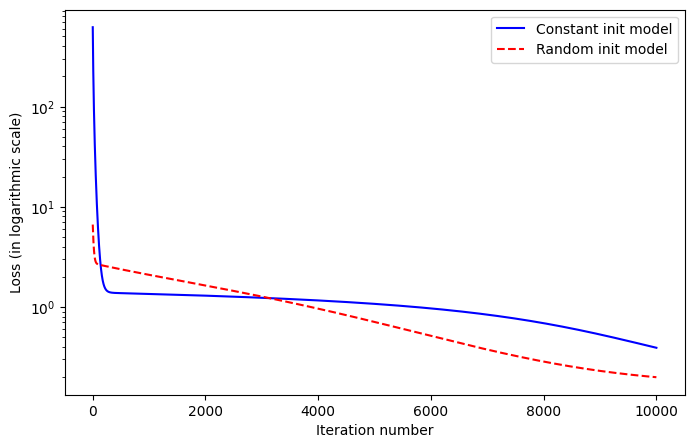

In [10]:
# Compare training curves
fig = plt.figure(figsize = (8, 5))
plt.plot(list(range(len(shallow_neural_net_const.losses_list))), \
            shallow_neural_net_const.losses_list, \
            "b", label = "Constant init model")
plt.plot(list(range(len(shallow_neural_net_rand.losses_list))), \
            shallow_neural_net_rand.losses_list, \
            "r--", label = "Random init model")
plt.xlabel("Iteration number")
plt.ylabel("Loss (in logarithmic scale)")
plt.yscale("log")
# Display
plt.legend(loc = "best")
plt.show()

### Which initialization is best then?

We have observed that a constant initialization is usually not a good idea, as it does not break symmetry. For this reason, it is often preferable to have some variance in the parameters and vectors produced during the **forward()** operations?

This, however, raises an important question: **which initialization method is best and should be used?**

In general, four initialization methods are considered in Neural Networks.

1. **The Normal Random initialization:** One simple approach is to initialize the weights of the network to random values drawn from a Gaussian distribution with a mean of 0 and a standard deviation of 0.01 or 0.1. This is a simple and effective method, but it can be sensitive to the choice of standard deviation, and was typically implemented in our original design 

```
self.W1 = np.random.randn(n_x, n_h)*0.1
self.b1 = np.random.randn(1, n_h)*0.1
self.W2 = np.random.randn(n_h, n_y)*0.1
self.b2 = np.random.randn(1, n_y)*0.1
```

2. **Xavier initialization:** Another popular method is Xavier initialization, which is designed to preserve the variance of the activations of the network as the weights are updated during training. This initialization technique is generally used for large networks with sigmoid or tanh activation functions and can help improve the convergence of the network. This would typically be implemented using a uniform distribution, as shown below:

```
# To ensure the variance is 1, we divide the range by the square root of the number of inputs
init_val = np.sqrt(6.0/(n_x + n_y))
self.W1 = np.random.uniform(-init_val, init_val, (n_x, n_h))
self.b1 = np.random.uniform(-init_val, init_val, (1, n_h))
self.W2 = np.random.uniform(-init_val, init_val, (n_h, n_y))
self.b2 = np.random.uniform(-init_val, init_val, (1, n_y))
```

It can also be implemented using a normal distribution, as shown below:
```
# To ensure the variance is 1, we divide the standard deviation by the square root of the number of inputs
std_dev = np.sqrt(3.0 / (input_size + output_size))
self.W1 = np.random.normal(0, std_dev, (n_x, n_h))
self.b1 = np.random.normal(0, std_dev, (1, n_h))
self.W2 = np.random.normal(0, std_dev, (n_h, n_y))
self.b2 = np.random.normal(0, std_dev, (1, n_y))
```

3. **He initialization:** Similar to Xavier initialization, He initialization is designed to preserve the variance of the activations, but it is specifically designed for large networks with ReLU activation functions. This would typically be implemented using a random normal for weights and zeroes for biases, as shown below:
```
range1 = np.sqrt(2/n_x)
self.W1 = np.random.randn(n_x, n_h)*range1
self.b1 = np.zeros((1, n_h))
range2 = np.sqrt(2/n_h)
self.W2 = np.random.randn(n_h, n_y)*range2
self.b2 = np.zeros((1, n_y))
```

4. **LeCun initialization:** This initialization technique is similar to Xavier initialization, but it is specifically designed for networks with sigmoid activation functions. It can be a good choice for networks with sigmoid activations and small networks. This would typically be implemented as:

```
range1 = np.sqrt(1/n_x)
self.W1 = np.random.randn(n_x, n_h)*range1
self.b1 = np.zeros((1, n_h))
range2 = np.sqrt(1/n_h)
self.W2 = np.random.randn(n_h, n_y)*range2
self.b2 = np.zeros((1, n_y))
```

**Important note:** these are empirical observations only. For this reason, it is a good idea to try a few different initialization techniques and see which one works best for your particular network architecture and dataset. Some recent research has also suggested that using a combination of different initialization techniques (e.g., random initialization for some layers and He initialization for others) can improve performance.

We will conclude this notebook by amending the **ShallowNeuralNet** class and bring in five additional methods for each possible initialization method and leave it to the reader to play with the different types of initializations to see their effects.

In [11]:
class ShallowNeuralNet():
    
    def __init__(self, n_x, n_h, n_y, init_type = "Normal"):
        # Network dimensions
        self.n_x = n_x
        self.n_h = n_h
        self.n_y = n_y
        # Initialize parameters
        self.init_type = init_type
        self.init_parameters()
        # Loss, initialized as infinity before first calculation is made
        self.loss = float("Inf")
        
    def init_parameters(self):
        if(self.init_type == "Normal"):
            self.init_parameters_normal()
        elif(self.init_type == "Xavier"):
            self.init_parameters_xavier()
        elif(self.init_type == "He"):
            self.init_parameters_he()
        elif(self.init_type == "LeCun"):
            self.init_parameters_lecun()
        elif(self.init_type == "Constant"):
            self.init_parameters_const()
        else:
            assert False, "Invalid initialization of parameters, check your init_type."
            
    def init_parameters_normal(self):
        # Weights and biases matrices (randomly initialized)
        self.W1 = np.random.randn(self.n_x, self.n_h)*0.1
        self.b1 = np.random.randn(1, self.n_h)*0.1
        self.W2 = np.random.randn(self.n_h, self.n_y)*0.1
        self.b2 = np.random.randn(1, self.n_y)*0.1
        
    def init_parameters_xavier(self):
        # Weights and biases matrices (Xavier initialized)
        init_val = np.sqrt(6.0/(self.n_x + self.n_y))
        self.W1 = np.random.uniform(-init_val, init_val, (self.n_x, self.n_h))
        self.b1 = np.random.uniform(-init_val, init_val, (1, self.n_h))
        self.W2 = np.random.uniform(-init_val, init_val, (self.n_h, self.n_y))
        self.b2 = np.random.uniform(-init_val, init_val, (1, self.n_y))
        
    def init_parameters_he(self):
        # Weights and biases matrices (He initialized)
        range1 = np.sqrt(2/self.n_x)
        self.W1 = np.random.randn(self.n_x, self.n_h)*range1
        self.b1 = np.zeros((1, self.n_h))
        range2 = np.sqrt(2/self.n_h)
        self.W2 = np.random.randn(self.n_h, self.n_y)*range2
        self.b2 = np.zeros((1, self.n_y))
        
    def init_parameters_lecun(self):
        # Weights and biases matrices (LeCun initialized)
        range1 = np.sqrt(1/self.n_x)
        self.W1 = np.random.randn(self.n_x, self.n_h)*range1
        self.b1 = np.zeros((1, self.n_h))
        range2 = np.sqrt(1/self.n_h)
        self.W2 = np.random.randn(self.n_h, self.n_y)*range2
        self.b2 = np.zeros((1, self.n_y))
        
    def init_parameters_const(self):
        # Weights and biases matrices (Constant initialized)
        const_val = 0.1
        self.W1 = np.ones(shape = (n_x, n_h))*const_val
        self.b1 = np.ones(shape = (1, n_h))*const_val
        self.W2 = np.ones(shape = (n_h, n_y))*const_val
        self.b2 = np.ones(shape = (1, n_y))*const_val
        
    def forward(self, inputs):
        # Wx + b operation for the first layer
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        # Wx + b operation for the second layer
        Z2 = np.matmul(Z1_b, self.W2)
        Z2_b = Z2 + self.b2
        return Z2_b
    
    def MSE_loss(self, inputs, outputs):
        # MSE loss function as before
        outputs_re = outputs.reshape(-1, 1)
        pred = self.forward(inputs)
        losses = (pred - outputs_re)**2
        self.loss = np.sum(losses)/outputs.shape[0]
        return self.loss
    
    def backward(self, inputs, outputs, alpha = 1e-5):
        # Get the number of samples in dataset
        m = inputs.shape[0]
        
        # Forward propagate
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        Z2 = np.matmul(Z1_b, self.W2)
        y_pred = Z2 + self.b2
    
        # Compute error term
        epsilon = y_pred - outputs
    
        # Compute the gradient for W2 and b2
        dL_dW2 = (2/m)*np.matmul(Z1_b.T, epsilon)
        dL_db2 = (2/m)*np.sum(epsilon, axis = 0, keepdims = True)

        # Compute the loss derivative with respect to the first layer
        dL_dZ1 = np.matmul(epsilon, self.W2.T)

        # Compute the gradient for W1 and b1
        dL_dW1 = (2/m)*np.matmul(inputs.T, dL_dZ1)
        dL_db1 = (2/m)*np.sum(dL_dZ1, axis = 0, keepdims = True)

        # Update the weights and biases using gradient descent
        self.W1 -= alpha*dL_dW1
        self.b1 -= alpha*dL_db1
        self.W2 -= alpha*dL_dW2
        self.b2 -= alpha*dL_db2
        
        # Update loss
        self.MSE_loss(inputs, outputs)
    
    def train(self, N_max = 1000, alpha = 1e-5, beta = 1e-5, display = True):
        # List of losses, starts with the current loss
        self.losses_list = [self.loss]
        # Repeat iterations
        for iteration_number in range(1, N_max + 1):
            # Backpropagate
            self.backward(inputs, outputs, alpha)
            new_loss = self.loss
            # Update losses list
            self.losses_list.append(new_loss)
            # Display
            if(display):
                print("Iteration {} - Loss = {}".format(iteration_number, new_loss))
            # Check for beta value and early stop criterion
            difference = abs(self.losses_list[-1] - self.losses_list[-2])
            if(difference < beta):
                if(display):
                    print("Stopping early - loss evolution was less than beta.")
                break
        else:
            # Else on for loop will execute if break did not trigger
            if(display):
                print("Stopping - Maximal number of iterations reached.")
    
    def show_losses_over_training(self):
        # Initialize matplotlib
        fig, axs = plt.subplots(1, 2, figsize = (15, 5))
        axs[0].plot(list(range(len(self.losses_list))), self.losses_list)
        axs[0].set_xlabel("Iteration number")
        axs[0].set_ylabel("Loss")
        axs[1].plot(list(range(len(self.losses_list))), self.losses_list)
        axs[1].set_xlabel("Iteration number")
        axs[1].set_ylabel("Loss (in logarithmic scale)")
        axs[1].set_yscale("log")
        # Display
        plt.show()

### What's next?

Below, we are trying the different initializations we have implemented and check their final loss values.

While it seems that the Normal and Lecun behave nicely, we end up with NaN values for Xavier and He initializations. This NaN value is a typical symptom for a phenomenon called the **exploding gradient syndrom**, which we will investigate in the next notebook.

In [12]:
# Define neural network structure (random normal initialization)
n_x = 2
n_h = 4
n_y = 1
init_type = "Normal"
np.random.seed(37)
shallow_neural_net_rand = ShallowNeuralNet(n_x, n_h, n_y, init_type)
# Train and show final loss
shallow_neural_net_rand.train(N_max = 10000, alpha = 1e-6, beta = 1e-6, display = False)
print(shallow_neural_net_rand.loss)

0.19879750888125622


In [13]:
# Define neural network structure (Xavier initialization)
n_x = 2
n_h = 4
n_y = 1
init_type = "Xavier"
np.random.seed(37)
shallow_neural_net_rand = ShallowNeuralNet(n_x, n_h, n_y, init_type)
# Train and show final loss
shallow_neural_net_rand.train(N_max = 10000, alpha = 1e-6, beta = 1e-6, display = False)
print(shallow_neural_net_rand.loss)

nan


In [14]:
# Define neural network structure (He initialization)
n_x = 2
n_h = 4
n_y = 1
init_type = "He"
np.random.seed(37)
shallow_neural_net_rand = ShallowNeuralNet(n_x, n_h, n_y, init_type)
# Train and show final loss
shallow_neural_net_rand.train(N_max = 10000, alpha = 1e-6, beta = 1e-6, display = False)
print(shallow_neural_net_rand.loss)

nan


In [15]:
# Define neural network structure (LeCun initialization)
n_x = 2
n_h = 4
n_y = 1
init_type = "LeCun"
np.random.seed(37)
shallow_neural_net_rand = ShallowNeuralNet(n_x, n_h, n_y, init_type)
# Train and show final loss
shallow_neural_net_rand.train(N_max = 10000, alpha = 1e-6, beta = 1e-6, display = False)
print(shallow_neural_net_rand.loss)

0.19672435697959575


### What's next?

In the next notebook, we will investigate the exploding gradient problem that we have observed in the Xavier and He initialization.